# Dataloading into Graph Construction Stage

**Goal**: Test the weighting and hard cut config of the data loading process

In [1]:
%load_ext autoreload
%autoreload 2

import os
import yaml

import numpy as np
import pandas as pd
import yaml
import torch
from torch_geometric.data import Data
import matplotlib.pyplot as plt

from time import time as tt

/global/homes/d/danieltm/.conda/envs/gnn4itk-cori/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Inspect Data Sample

In [2]:
from gnn4itk_cf.stages.graph_construction.utils import handle_weighting
from gnn4itk_cf.stages.graph_construction.models.utils import graph_intersection, build_edges
from gnn4itk_cf.stages.graph_construction.utils import *

/global/homes/d/danieltm/.conda/envs/gnn4itk-cori/lib/python3.9/site-packages/cudf/utils/gpu_utils.py:148: UserWarning: No NVIDIA GPU detected
  warnings.warn("No NVIDIA GPU detected")
ERROR:ptxcompiler.patch:Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "/global/homes/d/danieltm/.conda/envs/gnn4itk-cori/lib/python3.9/site-packages/numba/cuda/cudadrv/driver.py", line 246, in ensure_initialized
    self.cuInit(0)
  File "/global/homes/d/danieltm/.conda/envs/gnn4itk-cori/lib/python3.9/site-packages/numba/cuda/cudadrv/driver.py", line 319, in safe_cuda_api_call
    self._check_ctypes_error(fname, retcode)
  File "/global/homes/d/danieltm/.conda/envs/gnn4itk-cori/lib/python3.9/site-packages/numba/cuda/cudadrv/driver.py", line 387, in _check_ctypes_error
    raise CudaAPIError(retcode, msg)
numba.cuda.cudadrv.driver.CudaAPIError: [100] Call to cuInit results in CUDA_ERROR_NO_DEVICE

During handling of the above exception, another e

In [34]:
input_dir = "/global/cfs/cdirs/m3443/data/GNN4ITK/CommonFrameworkExamples/Example_1_Dev/module_map/trainset"
sample = torch.load(os.path.join(input_dir, "event000000100.pyg"), map_location="cpu")

## Toy Example

In [63]:
weighting_config = [
    {
        "weight": 1.0,
        "conditions": {"y": False}
    },
    {
        "weight": -1.0,
        "conditions": {"y": True,
                "pT": [0.0, 0.8]}
    }
    {
        "weight": 2.0,
        "conditions": {"y": True,
             "pT": [1.0, np.inf]}
    }
]

In [64]:
track_edges = torch.Tensor([
    [0, 1, 3, 4, 7, 9],
    [3, 4, 6, 7, 8, 10]
    ]).long()
pT = torch.Tensor([0.1, 1.1, 0.1, 1.1, 1.1, 2.0]).float()

In [66]:
true_edges = torch.cat([track_edges, track_edges.flip(0)], dim=1)

In [72]:
pred_edges = torch.Tensor([
    [1, 1, 2, 4, 6, 5, 7, 7],
    [2, 4, 5, 3, 3, 7, 8, 9]
]).long()

In [73]:
event = Data(pT = pT, track_edges = track_edges, edge_index = pred_edges)

In [74]:
event.y, truth_to_pred_map = graph_intersection(pred_edges, true_edges, return_truth_to_pred=True)

In [75]:
event

Data(edge_index=[2, 8], pT=[6], track_edges=[2, 6], y=[8])

In [76]:
truth_to_pred_map

tensor([-1,  1, -1, -1,  6, -1, -1, -1,  4, -1, -1, -1])

In [82]:
handle_weighting(event, weighting_config, pred_edges=pred_edges, truth=event.y, true_edges=event.track_edges, truth_map = truth_to_pred_map)

torch.Size([6]) torch.Size([12])
torch.Size([12]) torch.Size([12])


In [83]:
event.weights

tensor([1., 2., 1., 1., 0., 1., 2., 1.])

## Test Loading

In [3]:
from gnn4itk_cf.stages.graph_construction.models.metric_learning import MetricLearning

In [4]:
with open("metric_learning_train.yaml", "r") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
model = MetricLearning(config)

In [5]:
model.setup(stage="fit")

/global/u2/d/danieltm/ExaTrkX/GNN4ITkTeam/commonframework/gnn4itk_cf/utils/loading_utils.py:48: UserWarning: OPTIONAL feature [pid] not found in data
  warnings.warn(f"OPTIONAL feature [{feature}] not found in data")
/global/u2/d/danieltm/ExaTrkX/GNN4ITkTeam/commonframework/gnn4itk_cf/utils/loading_utils.py:48: UserWarning: OPTIONAL feature [n_hits] not found in data
  warnings.warn(f"OPTIONAL feature [{feature}] not found in data")
/global/u2/d/danieltm/ExaTrkX/GNN4ITkTeam/commonframework/gnn4itk_cf/utils/loading_utils.py:48: UserWarning: OPTIONAL feature [pdg_id] not found in data
  warnings.warn(f"OPTIONAL feature [{feature}] not found in data")
/global/u2/d/danieltm/ExaTrkX/GNN4ITkTeam/commonframework/gnn4itk_cf/utils/loading_utils.py:48: UserWarning: OPTIONAL feature [ghost] not found in data
  warnings.warn(f"OPTIONAL feature [{feature}] not found in data")
/global/u2/d/danieltm/ExaTrkX/GNN4ITkTeam/commonframework/gnn4itk_cf/utils/loading_utils.py:48: UserWarning: OPTIONAL featur

In [6]:
for batch in model.train_dataloader():
    print(batch)

    break

DataBatch(hit_id=[15943], x=[15943], y=[15943], z=[15943], r=[15943], phi=[15943], eta=[15943], region=[15943], cluster_x_1=[15943], cluster_y_1=[15943], cluster_z_1=[15943], cluster_x_2=[15943], cluster_y_2=[15943], cluster_z_2=[15943], norm_x=[15943], norm_y=[15943], norm_z_1=[15943], eta_angle_1=[15943], phi_angle_1=[15943], eta_angle_2=[15943], phi_angle_2=[15943], norm_z_2=[15943], track_edges=[2, 14587], particle_id=[14587], pt=[14587], radius=[14587], primary=[14587], nhits=[14587], pdgId=[14587], config=[1], event_id=[1], batch=[15943], ptr=[2])


/global/homes/d/danieltm/.conda/envs/gnn4itk-cori/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


### Visualize

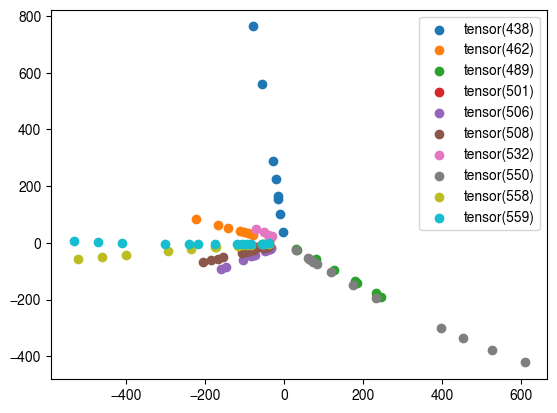

In [8]:
for pid in batch.particle_id.unique()[:10]:
    pid_edges = batch.track_edges[:, batch.particle_id == pid]
    x = batch.x[pid_edges]
    y = batch.y[pid_edges]
    plt.scatter(x[0], y[0], label=pid)
plt.legend()

In [9]:
batch.edge_index, embedding = model.get_training_edges(batch)

In [10]:
model.apply_embedding(batch, embedding, batch.edge_index)

In [11]:
batch.edge_index, batch.y, truth_map, true_edges = model.get_truth(batch, batch.edge_index)

In [12]:
batch.y.shape, batch.y.sum()

(torch.Size([797054]), tensor(18459))

In [13]:
true_edges.shape

torch.Size([2, 29174])

In [14]:
weights = model.get_weights(batch, true_edges, truth_map)

In [17]:
((batch.y == 1.0) & (weights > 0.0)).sum()

tensor(16030)

In [18]:
((batch.y == 0.0) & (weights > 0.0)).sum()

tensor(778595)

In [20]:
((batch.y == 1.0) & (weights <= 0.0)).sum()

tensor(2429)

In [135]:
(weights == 1.0).all()

tensor(False)

In [136]:
model.loss_function(batch, embedding, weights)

tensor(0.0166, grad_fn=<AddBackward0>)

## Debug Weighting

In [7]:
weights = handle_weighting(batch, model.hparams["weighting"], true_edges=true_edges, truth_map=truth_map)

NameError: name 'true_edges' is not defined

In [89]:
pred_edges = batch.edge_index
truth = batch.y

In [90]:
weights = torch.zeros_like(pred_edges[0], dtype=torch.float)
weights[truth == 0] = 1.0

In [96]:
weight_spec = model.hparams["weighting"][0]
weight_val = weight_spec["weight"]

In [104]:
get_weight_mask(batch, pred_edges, weight_spec["conditions"], true_edges, truth_map).sum()

tensor(1571465)

In [105]:
weight_spec = model.hparams["weighting"][1]
weight_val = weight_spec["weight"]

In [106]:
get_weight_mask(batch, pred_edges, weight_spec["conditions"], true_edges, truth_map).sum()

tensor(29174)

In [122]:
graph_mask = torch.ones_like(pred_edges[0], dtype=torch.bool)

In [123]:
for condition_key, condition_val in weight_spec["conditions"].items():
    print(condition_key, condition_val)
    assert condition_key in batch.keys, f"Condition key {condition_key} not found in event keys {batch.keys}"
    condition_lambda = get_condition_lambda(condition_key, condition_val)
    value_mask = condition_lambda(batch)
    print(value_mask.shape, value_mask.sum())
    edgelike_mask = map_value_to_edges(batch, value_mask, pred_edges, true_edges, truth_map)
    print(edgelike_mask.shape, edgelike_mask.sum())
    graph_mask &= edgelike_mask
    print(graph_mask.shape, graph_mask.sum())

y True
torch.Size([1600639]) tensor(29174)
torch.Size([1600639]) tensor(29174)
torch.Size([1600639]) tensor(29174)
pt [1000, inf]
torch.Size([14587]) tensor(14587)
torch.Size([1600639]) tensor(29174)
torch.Size([1600639]) tensor(29174)
nhits [3, inf]
torch.Size([14587]) tensor(14530)
torch.Size([1600639]) tensor(29060)
torch.Size([1600639]) tensor(29060)
primary True
torch.Size([14587]) tensor(12510)
torch.Size([1600639]) tensor(25020)
torch.Size([1600639]) tensor(24968)
pdgId ['not_in', [11, -11]]
torch.Size([14587]) tensor(14061)
torch.Size([1600639]) tensor(28122)
torch.Size([1600639]) tensor(24900)


In [113]:
condition_key = "nhits"
condition_val = [3, np.inf]

In [114]:
condition_lambda = get_condition_lambda(condition_key, condition_val)
value_mask = condition_lambda(batch)

In [116]:
true_edges is not None and value_mask.shape[0] in [true_edges.shape[1], 2 * true_edges.shape[1]]

False

In [120]:
value_mask.shape[0] * 2

29174

In [121]:
true_edges.shape[1]

29174

## Debug Metrics

In [8]:
embedding = model.apply_embedding(batch)

In [9]:
batch.edge_index = build_edges(
            query=embedding, database=embedding, indices=None, r_max=0.1, k_max=10, backend="FRNN"
        )

In [10]:
batch.edge_index, batch.y, truth_map, true_edges = model.get_truth(batch, batch.edge_index)

In [11]:
weights = model.get_weights(batch, true_edges, truth_map)

In [12]:
weights.shape, (weights > 0).sum()

(torch.Size([143468]), tensor(141932))

In [34]:
signal_true_edges = build_signal_edges(batch, model.hparams["weighting"], true_edges)

In [35]:
true_edges.shape

torch.Size([2, 29174])

In [36]:
signal_true_edges.shape

torch.Size([2, 24900])

In [32]:
signal_mask = torch.zeros_like(true_edges[0], dtype=torch.bool)

In [33]:
for weight_spec in model.hparams["weighting"]:
    print(weight_spec)
    if not weight_spec["conditions"]["y"] or weight_spec["weight"] <= 0.:
        continue
    weight_mask = get_weight_mask(batch, true_edges, weight_spec["conditions"])
    print(weight_mask.shape, weight_mask.sum())
    signal_mask |= weight_mask
    print(signal_mask.shape, signal_mask.sum())

{'weight': 1.0, 'conditions': {'y': False}}
{'weight': -1.0, 'conditions': {'y': True, 'pt': [0.0, 800.0]}}
{'weight': -1.0, 'conditions': {'y': True, 'primary': False}}
{'weight': 2.0, 'conditions': {'y': True, 'pt': [1000, inf], 'nhits': [3, inf], 'primary': True, 'pdgId': ['not_in', [11, -11]]}}
torch.Size([29174]) tensor(24900)
torch.Size([29174]) tensor(24900)


In [37]:
not weight_spec["conditions"]["y"] or weight_spec["weight"] <= 0.

False

In [159]:
weight_spec = model.hparams["weighting"][1]
weight_val = weight_spec["weight"]

In [160]:
graph_mask = torch.ones_like(true_edges[0], dtype=torch.bool)

for condition_key, condition_val in weight_spec["conditions"].items():
    print(condition_key, condition_val)
    assert condition_key in batch.keys, f"Condition key {condition_key} not found in event keys {batch.keys}"
    condition_lambda = get_condition_lambda(condition_key, condition_val)
    value_mask = condition_lambda(batch)
    print(value_mask.shape, value_mask.sum())
    edgelike_mask = map_value_to_edges(batch, value_mask, true_edges, None, None)
    print(edgelike_mask.shape, edgelike_mask.sum())
    graph_mask &= edgelike_mask
    print(graph_mask.shape, graph_mask.sum())

y True
torch.Size([1577186]) tensor(21566)
torch.Size([29174]) tensor(29174)
torch.Size([29174]) tensor(29174)
pt [1000, inf]
torch.Size([14587]) tensor(14587)
torch.Size([29174]) tensor(29174)
torch.Size([29174]) tensor(29174)
nhits [3, inf]
torch.Size([14587]) tensor(14530)
torch.Size([29174]) tensor(29060)
torch.Size([29174]) tensor(29060)
primary True
torch.Size([14587]) tensor(12510)
torch.Size([29174]) tensor(25020)
torch.Size([29174]) tensor(24968)
pdgId ['not_in', [11, -11]]
torch.Size([14587]) tensor(14061)
torch.Size([29174]) tensor(28122)
torch.Size([29174]) tensor(24900)


In [164]:
signal_mask.sum()

tensor(24900)

## Building Undirected Graph

In [26]:
t = torch.tensor([
    [0, 1],
    [1, 2]
])
e = torch.tensor([
    [0, 1, 2, 1],
    [1, 0, 1, 2]
])
mapstar = torch.tensor([0, 3, 1, 2])
tstar = torch.tensor([
    [0, 1, 1, 2],
    [1, 2, 0, 1]
])
y = torch.tensor([1, 1, 0, 0])

In [27]:
e[:, e[0] > e[1]] = e[:, e[0] > e[1]].flip(0)

In [28]:
estar, inverse = e.unique(return_inverse=True, dim=-1)

In [29]:
e

tensor([[0, 0, 1, 1],
        [1, 1, 2, 2]])

In [30]:
estar, inverse

(tensor([[0, 1],
         [1, 2]]),
 tensor([0, 0, 1, 1]))

In [31]:
inverse[mapstar]

tensor([0, 1, 0, 1])

In [33]:
# Scatter y to inverse
torch.scatter(y, 0, inverse, 0,

tensor([0, 0, 0, 0])

In [38]:
y.scatter(0, inverse, inverse)

tensor([0, 1, 0, 0])

In [42]:
torch.zeros_like(y[:2]).scatter(0, inverse, y)

tensor([1, 0])

In [51]:
a = torch.tensor([0, 1])

In [52]:
if a.shape:
    print("YES")

YES
